In [1]:
import h5py
import numpy as np
from numpy import newaxis
import cv2
import sys
import os
from osgeo import gdal,osr,ogr

import matplotlib.pyplot as plt

/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
OUTPUT_CHANNELS=1
INPUT_CHANNELS=17

NAME_PANCHRO='panchro.tif'
NAME_PANSHARP='pansharp.tif'
NAME_MS='ms.tif'


In [6]:

def read_images(path):
    '''
    Reads tif images (panchromatic, MS, pansharpened)
    :path where is the image
    '''
    raster = gdal.Open(path)
    data = np.array(raster.ReadAsArray())
    return data

def read_labels(path):
    '''
    Reads png images (label mask groundtruth)
    :path where is the image
    '''
    data=cv2.imread(path,cv2.IMREAD_UNCHANGED)
    return data

def read_data_h5(path):
    '''
    Reads h5 file
    :path path of the file to read
    returns data as an array
    '''
    with h5py.File(path, 'r') as hf:
        data=np.array(hf.get('data'))
    return data

def write_data_h5(path,data_):
    '''
    Writes h5 file
    :path path of the file to write
    :data_ data to write into the file
    '''
    with h5py.File(path,'w') as hf:
           hf.create_dataset('data',data=data_)
    print('File'+path+' created')




In [7]:
def plot_images(image,figsize=(8,8), plot_name='',add_title=False,save_path='',save_images=False):
    '''
    Plot each band of an image
    :image numpy array, should be width x height x number_channels
    '''
    
    number_channels=image.shape[2]
    
    fig, axs = plt.subplots(1, number_channels, figsize=(number_channels*figsize[0], figsize[1]))

    if number_channels==1:
        axs=[axs]
    
    if add_title:
        suptitle = fig.suptitle(plot_name.split('/')[-1], fontsize='large')
    for i in range(number_channels):
        axs[i].imshow(image[:,:,i])
        axs[i].set_title('Band '+str(i))
        if save_images:
            print('Save image %s band %d'%(plot_name,i))
            plt.imsave(save_path+plot_name+'_'+str(i)+'.png',image[:,:,i])
        
    plt.tight_layout()
    if add_title:
        suptitle.set_y(0.95)
        fig.subplots_adjust(top=0.96)
    

In [8]:
def createRasterFromGeoJson(srcGeoJson, srcRasterFileName, outRasterFileName):
    NoData_value = 0
    source_ds = ogr.Open(srcGeoJson)
    source_layer = source_ds.GetLayer()

    srcRaster = gdal.Open(srcRasterFileName)


    # Create the destination data source
    target_ds = gdal.GetDriverByName('GTiff').Create(outRasterFileName, srcRaster.RasterXSize, srcRaster.RasterYSize, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform(srcRaster.GetGeoTransform())
    target_ds.SetProjection(srcRaster.GetProjection())
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(NoData_value)

    # Rasterize
    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])
    band.FlushCache()



Display Pansharpened
Save image Pansharpened_Bands band 0
Save image Pansharpened_Bands band 1
Save image Pansharpened_Bands band 2
Save image Pansharpened_Bands band 3
Save image Pansharpened_Bands band 4
Save image Pansharpened_Bands band 5
Save image Pansharpened_Bands band 6
Save image Pansharpened_Bands band 7
Display Panchromatic
Save image Panchromatic_Band band 0
Display MS
Save image Multi_Spectral_Bands band 0
Save image Multi_Spectral_Bands band 1
Save image Multi_Spectral_Bands band 2
Save image Multi_Spectral_Bands band 3
Save image Multi_Spectral_Bands band 4
Save image Multi_Spectral_Bands band 5
Save image Multi_Spectral_Bands band 6
Save image Multi_Spectral_Bands band 7
Display Labels
Save image groundtruth band 0


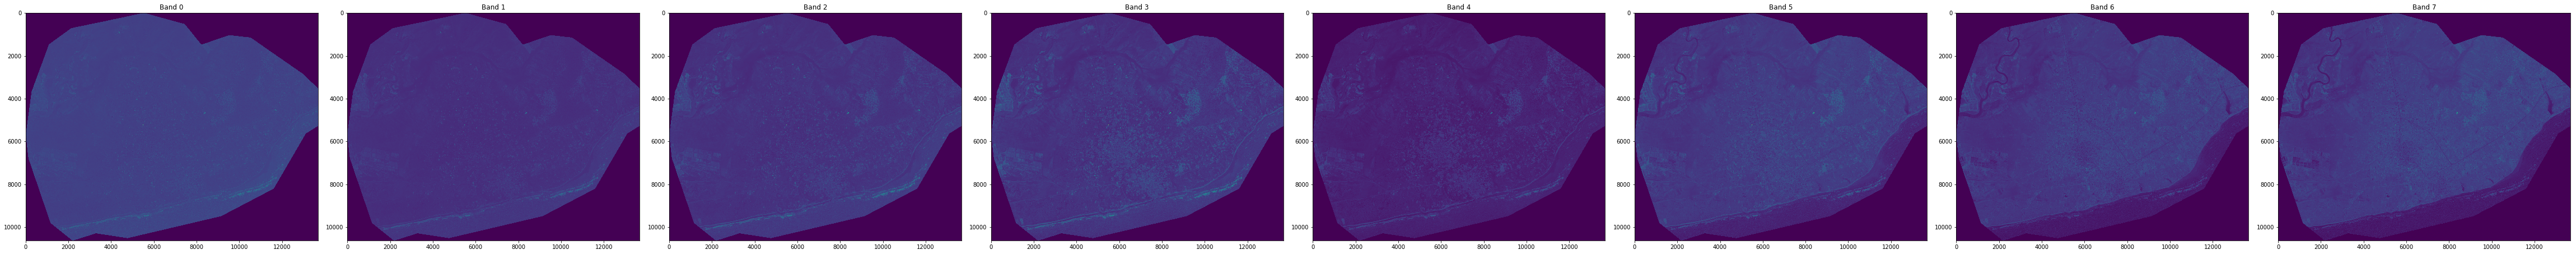

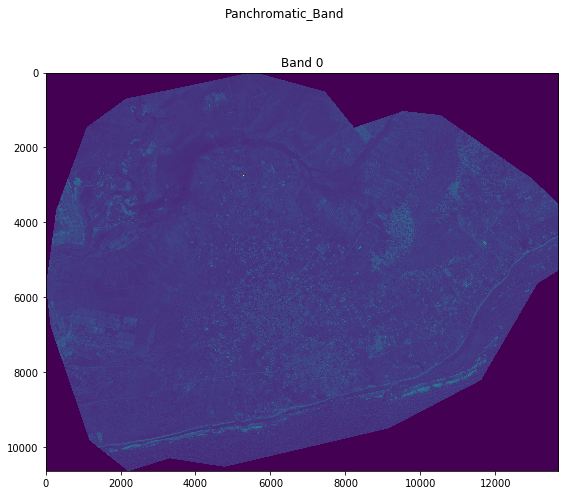

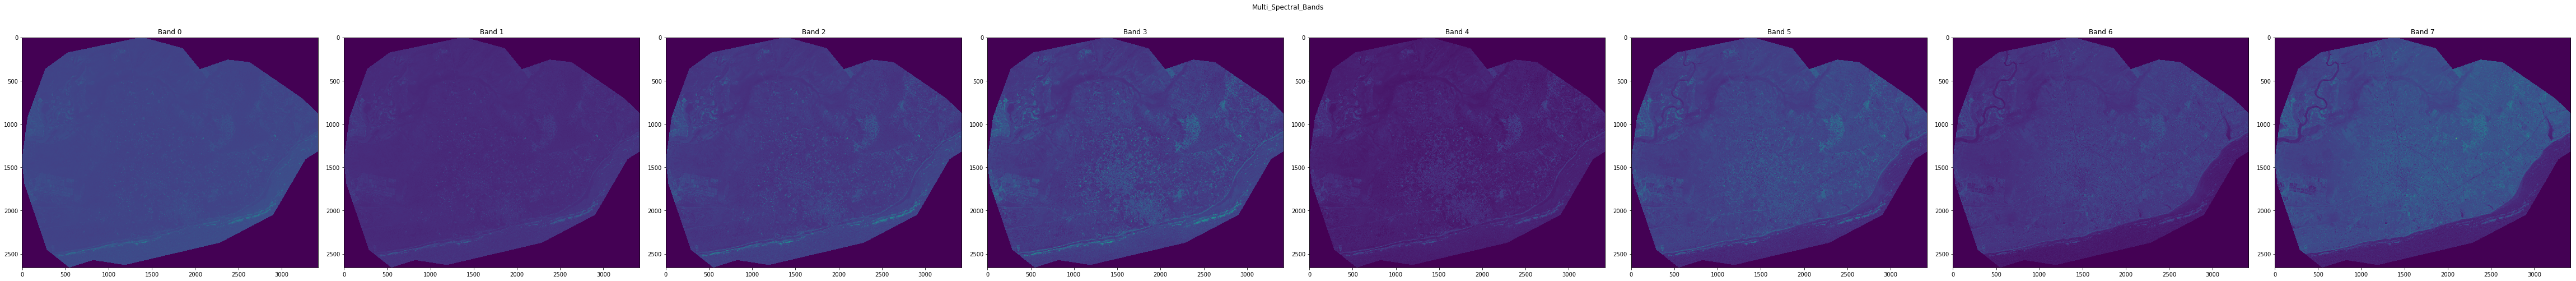

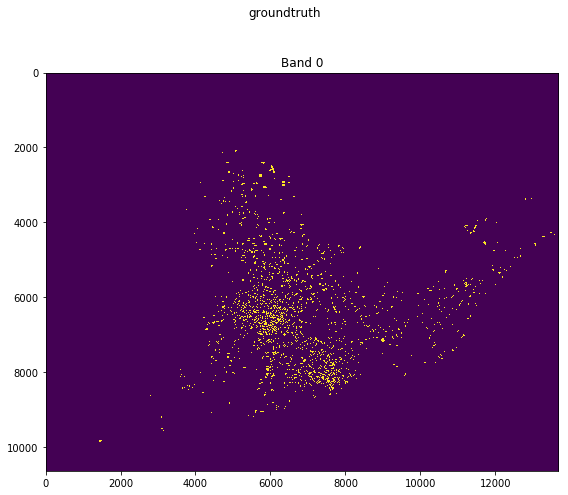

In [9]:
if __name__ == '__main__':


    path='../DATA_GHANA/RAW_DATA/'
    geojson_file=path+'buildings_accra.geojson'
    
    save_folder=path+'test_display/'
    if not os.path.exists(save_folder):
            os.makedirs(save_folder)
            
    name_labels=path+'groundtruth.png'
    
    ## Display Pansharpened
    print('Display Pansharpened')
    pansharpened_file=path+NAME_PANSHARP
    pansharpened=read_images(pansharpened_file)
    pansharpened=np.transpose(pansharpened,(1,2,0))
    plot_images(pansharpened,figsize=(8,8), plot_name='Pansharpened_Bands',add_title=False,save_path=save_folder,save_images=True)
    
    ## Display Panchromatic
    print('Display Panchromatic')
    panchromatic_file=path+NAME_PANCHRO
    panchromatic=read_images(panchromatic_file)
    panchromatic=panchromatic[:,:,newaxis]
    plot_images(panchromatic,figsize=(8,8), plot_name='Panchromatic_Band',add_title=True,save_path=save_folder,save_images=True)
    
    ## Display MS
    print('Display MS')
    ms_file=path+NAME_MS
    ms=read_images(ms_file)
    ms=np.transpose(ms,(1,2,0))
    plot_images(ms,figsize=(8,8), plot_name='Multi_Spectral_Bands',add_title=True,save_path=save_folder,save_images=True)
    
#     ## Display  Labels
    print('Display Labels')
    createRasterFromGeoJson(geojson_file, panchromatic_file,name_labels)
    labels=read_images(name_labels)
    labels=labels[:,:,newaxis]
    plot_images(labels,figsize=(8,8), plot_name='groundtruth',add_title=True,save_path=save_folder,save_images=True)
    
    